In [1]:
import pandas as pd
import zipfile
from elopy.elo import Elo
import matplotlib.pyplot as plt

In [2]:
with zipfile.ZipFile('data/contest_results.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('extracted_files')

df = pd.read_csv('./extracted_files/contest_results.csv', parse_dates=['contest_date'])
df.loc[df['placing'] > 16, 'placing'] = 16
df = df[['organization', 'contest_name', 'contest_date', 'division', 'class', 'competitor_name', 'placing']]
df.loc[df["division"] == "women\'s wellness", "division"] = "wellness"
df = df.dropna()

In [3]:
# every pair of competitors from the same show & division get a row
# think of this as a "match" in chess
df_merge = pd.merge(df,
                    df,
                    on=['organization', 'contest_name', 'contest_date', 'division', 'class'],
                    how='inner',
                    suffixes=('_winner', '_loser'))

In [4]:
df_merge = df_merge[df_merge['placing_winner'] < df_merge['placing_loser']]
df_merge.head()

,organization,contest_name,contest_date,division,class,competitor_name_winner,placing_winner,competitor_name_loser,placing_loser
6,cpa,cpa fedel clarke classic,2018-03-25,bikini,class a,tasha chase,5.0,laura mcintosh,6.0
12,cpa,cpa fedel clarke classic,2018-03-25,bikini,class a,sarah farrer,4.0,laura mcintosh,6.0
13,cpa,cpa fedel clarke classic,2018-03-25,bikini,class a,sarah farrer,4.0,tasha chase,5.0
18,cpa,cpa fedel clarke classic,2018-03-25,bikini,class a,neha dhanda,3.0,laura mcintosh,6.0
19,cpa,cpa fedel clarke classic,2018-03-25,bikini,class a,neha dhanda,3.0,tasha chase,5.0


# Elo Rating Column
Here we will create a column in df_merge which includes the competitor's Elo rating leading up to that competition.

In [5]:
df = df.sort_values(
    by=[
        "contest_date",
        "organization",
        "contest_name",
        "division",
        "class",
        "competitor_name"
    ],
    ascending=True,
)

In [8]:
competitors = {}
starting_elo = {"bikini": 1700,
                "figure": 1650,
                "fitness": 1525,
                "men\'s bodybuilding": 1650,
                "men\'s classic physique": 1625,
                "men\'s physique": 1650,
                "wellness": 1575,
                "women\'s bodybuilding": 1625,
                "women\'s physique": 1550,
                "212": 1650}

for contest_date in df["contest_date"].unique():
    for index, row in df[df["contest_date"] == contest_date].iterrows():

        if row["competitor_name"] not in competitors:
            if row["organization"] != "ifbb":
                competitors[row["competitor_name"]] = Elo()
            else:
                div = row["division"]
                competitors[row["competitor_name"]] = Elo(start_elo=starting_elo[div])
        df.loc[index, f"elo_rating"] = competitors[row["competitor_name"]].elo

    for index, row in df_merge[df_merge["contest_date"] == contest_date].iterrows():
        winner = row["competitor_name_winner"]
        loser = row["competitor_name_loser"]
        rank_diff = row["placing_loser"] - row["placing_winner"]

        competitors[winner].play_game(competitors[loser], rank_diff)

In [9]:
df[f"elo_rank"] = df.groupby(
    ["organization", "contest_date", "contest_name", "division", "class"]
)[f"elo_rating"].rank(ascending=False, method="first")
df.loc[df[f"elo_rank"] > 16, f"elo_rank"] = 16

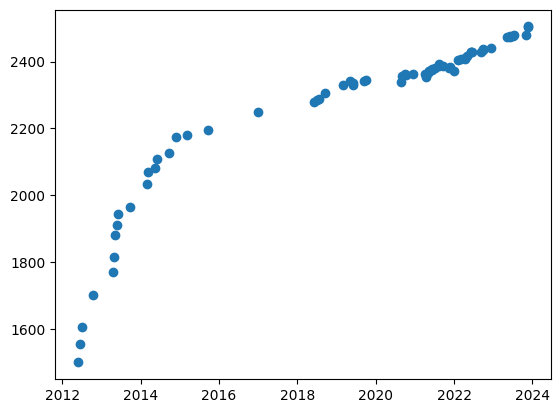

In [11]:
plt.scatter(df[df['competitor_name'] == 'ashley kaltwasser']['contest_date'],
            df[df['competitor_name'] == 'ashley kaltwasser'][f'elo_rating'])

In [12]:
df.head()

,organization,contest_name,contest_date,division,class,competitor_name,placing,elo_rating,elo_rank
17038,ifbb,ifbb flex pro,2012-02-18,fitness,open,adela garcia,1.0,1525.0,1.0
17030,ifbb,ifbb flex pro,2012-02-18,fitness,open,allison ethier,9.0,1525.0,2.0
17034,ifbb,ifbb flex pro,2012-02-18,fitness,open,bethany wagner,5.0,1525.0,3.0
17031,ifbb,ifbb flex pro,2012-02-18,fitness,open,camala rodriguez,8.0,1525.0,4.0
17033,ifbb,ifbb flex pro,2012-02-18,fitness,open,jodi boam,6.0,1525.0,5.0


In [13]:
df.to_csv('contest_results_elo_adjusted.csv')

In [14]:
max_date = df['contest_date'].max()

df[df['contest_date'] == max_date]['elo_rating'].mean()

1511.591591203174

In [18]:
olympia_date = df[df['contest_name'].str.contains('olympia')]["contest_date"].max()

In [23]:
df[(df["contest_date"] == olympia_date)]

,organization,contest_name,contest_date,division,class,competitor_name,placing,elo_rating,elo_rank
780829,npcw,npc worldwide invictus pro qualifier,2023-11-25,bikini,class b,akerke nurpeisova,5.0,1500.000000,1.0
780830,npcw,npc worldwide invictus pro qualifier,2023-11-25,bikini,class b,angelina burak,4.0,1500.000000,2.0
780832,npcw,npc worldwide invictus pro qualifier,2023-11-25,bikini,class b,kristina novitskaya,2.0,1500.000000,3.0
780833,npcw,npc worldwide invictus pro qualifier,2023-11-25,bikini,class b,mariia eliseeva,1.0,1500.000000,4.0
780831,npcw,npc worldwide invictus pro qualifier,2023-11-25,bikini,class b,sheyda karami,3.0,1468.410500,5.0
...,...,...,...,...,...,...,...,...,...
781765,npcw,npc worldwide spanish grand prix,2023-11-25,wellness,class a,elena olano alcubierre,1.0,1464.611268,3.0
781763,npcw,npc worldwide spanish grand prix,2023-11-25,wellness,class a,sol silva,3.0,1491.925745,2.0
781767,npcw,npc worldwide spanish grand prix,2023-11-25,wellness,class b,maria eliane miranda,1.0,1500.000000,2.0
781766,npcw,npc worldwide spanish grand prix,2023-11-25,wellness,class b,patricia gomez mengual,2.0,1525.187289,1.0
